## DEFINICIÓN DE CONSTANTES FUNDAMENTALES  

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Definir las constantes
g = 9.8 # gravedad [m/s^2]
p_atm = 101325 # Presión atmosférica [Pa]
beta = 3.67e-3 # Coeficiente de expansion termica [1/K]
T_w = 80.0 + 273.0 # Temperatura de la pared [K]
T_a = 20.0 + 273.0 # Temperatura ambiente [K]
delta_T = T_w - T_a
lambda_f = 0.04 # Coeficiente de friccion [adimensional]
R = 10.0 # Radio de la tuberia [m]
L = 100.0 # Longitud de la tuberia [m]
D = 2 * R
alpha = 2.2e-5 # Coeficiente de difusividad [m^2/s]
rho_0 = 1.0 # Densidad [kg/m^3]
Cp = 1.012 # Capacidad calorifica [J/(kg K)]
k = 0.024 # Conductividad termica [W/(m K)]
nu = 1.71e-5 # Viscosidad [Pa s]
Ra_D = (g * beta * delta_T * (2 * R)**3)/ nu**2 # Numero de Rayleigh
Nu = (576/(Ra_D * 2 * R /L)**2 + 2.873/(Ra_D * 2 * R /L)**(1/2))**(-1/2)# Numero de Nusselt
h_v = (k * Nu)/ (2 * R * L) # coeficiente de tranferencia de calor por convección [W/(m^3 K)]
h = 1.42 * (delta_T/L)**(1/4)

## DEFINICIÓN DE VALORES ADIMENSIONALES

In [15]:
phi = 1/ (beta * delta_T)
Ri = 2 * rho_0**2 * g * beta * L * Cp**2 * delta_T /  h**2 # Numero de Richardson
Ra = rho_0**2 * g * beta * Cp * D**2 * delta_T / (16 * nu * h) # Numero de Rayleigh
LAMBDA = L/D # Relación de aspecto
delta = alpha * h / (L**2 * rho_0 * g * beta * Cp * delta_T)

print(f'Numero de Richards: {Ri:.2e} \nNumero de Rayleigh: {Ra:.2e} \nphi: {phi:.4f}')

# Para tener un flujo laminar el numero de Rayleigh tienen que ser menor que 1e9

Numero de Richards: 2.83e+02 
Numero de Rayleigh: 2.55e+06 
phi: 4.5413


## CALCULO DE v_e POR NEWTON-RAPHSON

In [16]:
import math

def f(v, a, b, c, d):
    return a + b*v**2 + c*v - 1 + (v/d)*(1 - math.exp(-d/v))

def f_prime(v, b, c, d):
    return 2*b*v + c + (1/d)*(1 - math.exp(-d/v)) - (1/(d * v))*math.exp(-d/v)

def newton_raphson(a, b, c, d, v0, tol=1e-6, max_iter=100):
    v = v0
    for i in range(max_iter):
        v_new = v - f(v, a, b, c, d) / f_prime(v, b, c, d)
        if abs(v_new - v) < tol:
            return v_new, i+1
        v = v_new
    return v, max_iter  # Retorna la última aproximación si no converge

# Ejemplo de uso
a = phi
b = Ri**-1
c = Ra**-1
d = LAMBDA
v0 = 0.1  # Valor inicial

v_sol, iterations = newton_raphson(a, b, c, d, v0)
print(f"La solución aproximada es v_e = {v_sol:.6f}")
print(f"Número de iteraciones: {iterations}")

# Verificar la solución
residual = f(v_sol, a, b, c, d)
print(f"Residual: {residual:.2e}")

v_e = v_sol


La solución aproximada es v_e = 7.241852
Número de iteraciones: 100
Residual: 4.45e+00


## LA VELOCIDAD EN EL ESTACIONARIO SERÁ

In [17]:
u_e = v_e * h_v * L / (rho_0 * Cp)
print(f'u_e = {u_e:.2f} m/s o {u_e*3.6:.2f} km/h')

u_e = 9.39 m/s o 33.81 km/h


## DISTRIBUCIÓN DE TEMPERATURAS

El valor de theta cuando eta = 1 es: 0.4986


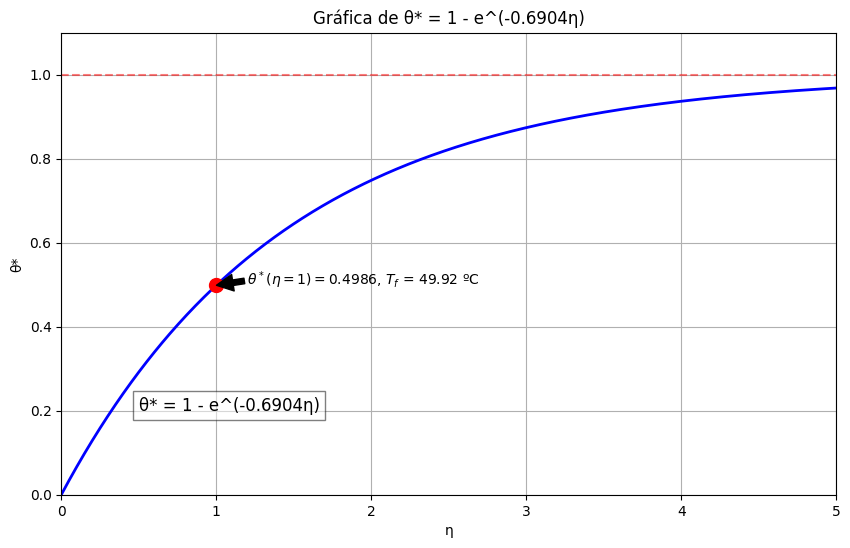

In [18]:
def theta_estrella(eta, a):
    return 1 - np.exp(-a * eta)

# Parámetros
a = LAMBDA / v_e  # Puedes cambiar este valor según tus necesidades

# Crear un rango de valores para eta
eta = np.linspace(0, 5, 1000)  # Ajusta el rango según sea necesario

# Calcular theta_estrella para cada valor de eta
theta = theta_estrella(eta, a)

# Calcular theta cuando eta = 1
eta_1 = 1
theta_1 = theta_estrella(eta_1, a)

# Calculo de la temperatura en K
T_f = delta_T * theta_1 + T_a

print(f"El valor de theta cuando eta = 1 es: {theta_1:.4f}")

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(eta, theta, 'b-', linewidth=2)
plt.title(f'Gráfica de θ* = 1 - e^(-{a:.4f}η)')
plt.xlabel('η')
plt.ylabel('θ*')
plt.grid(True)
plt.axhline(y=1, color='r', linestyle='--', alpha=0.5)  # Línea asintótica en y=1
plt.xlim(0, max(eta))
plt.ylim(0, 1.1)

# Marcar el punto (1, theta_1) en la gráfica
plt.plot(1, theta_1, 'ro', markersize=10)  # 'ro' significa un punto rojo
plt.annotate(r'$\theta^* (\eta = 1) = $' + f'{theta_1:.4f}' + f', $T_f$ = {T_f-273:.2f} ºC', xy=(1, theta_1), xytext=(1.2, theta_1),
             arrowprops=dict(facecolor='black', shrink=0.005))

# Añadir una ecuación en la gráfica
plt.text(0.5, 0.2, f'θ* = 1 - e^(-{a:.4f}η)', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.show()


## DISTRIBUCIÓN DE PRESIONES

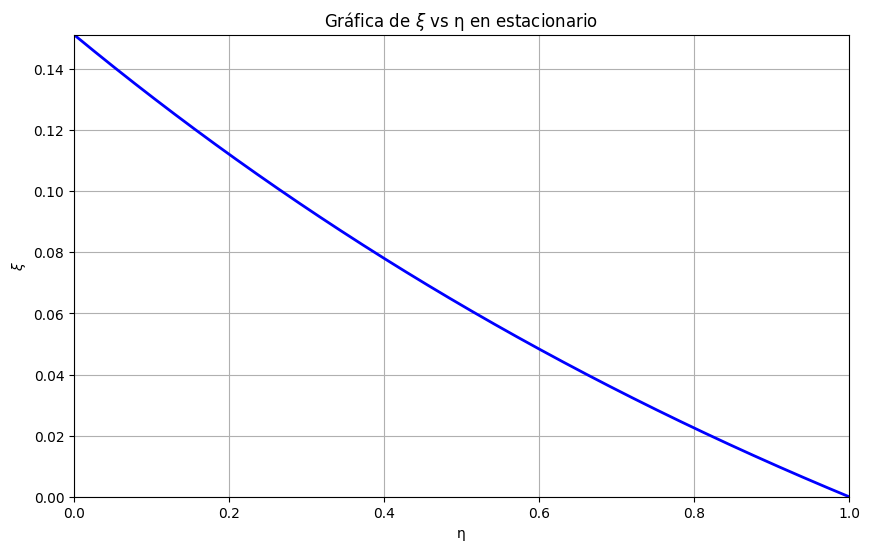

In [19]:
def xi_fun(eta, v_e, Ra, phi, LAMBDA):
    return v_e**2 / (Ra * phi) * (1 - eta) - LAMBDA / (phi * v_e) * (1 - np.exp(-(LAMBDA/v_e) * (eta - 1)))

# Crear un rango de valores para eta
eta = np.linspace(0, 1, 1000)  # Ajusta el rango según sea necesario

# Calcular theta_estrella para cada valor de eta
xi_dist = xi_fun(eta, v_e, Ra, phi, LAMBDA)

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(eta, xi_dist, 'b-', linewidth=2)
plt.title(f'Gráfica de ' + r'$\xi$ vs η en estacionario')
plt.xlabel('η')
plt.ylabel(r'$\xi$')
plt.grid(True)
plt.axhline(y=1, color='r', linestyle='--', alpha=0.5)  # Línea asintótica en y=1
plt.xlim(0, max(eta))
plt.ylim(0, max(xi_dist))

# Añadir una ecuación en la gráfica
#plt.text(0.5, 0.2, f'θ* = 1 - e^(-{a:.4f}η)', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.show()

## SIMULACIÓN NUMÉRICA

In [20]:
# Definición de variables y condiciones iniciales
M = 256 # Número de puntos en la dirección vertical
N = 512 # Número de puntos en la dirección temporal
eta = np.linspace(0, 1, M)  # Coordenada vertical adimensional
tau = np.linspace(0, 1, N)  # Coordenada temporal adimensional
deta = (eta[-1] - eta[0])/M
dtau = (tau[-1] - tau[0])/N 
v = np.zeros(N)  # Velocidad adimensional
theta_star = np.zeros((M, N))  # Temperatura adimensional
xi = np.zeros((M, N))  # Presión adimensional, inicialmente todo el espacio se encuentra a p_atm

# Condiciones iniciales
v[0] = 0.0  # Velocidad inicial cero
# theta_star[:, 0] = 0.0   Temperatura inicial uniforme
# xi[:, 0] = 0.0 Diferencia de presión entre el interior del tubo y el exterior

# Simulación numérica

for t in range(1, N-1):


    # Calculo de la velocidad en el instante i+1 a partir de la presión en eta = 0 del instante anterior:
    v[t] = np.sqrt(Ri * phi * xi[0, t-1]) / v_e

    # Calculo de las distribuciones de temperatura y presion en el espacio para el instante i+1:
    for x in range(M-1):
         
        dtheta_deta = (theta_star[x+1, t-1] - theta_star[x, t-1]) / deta
        d2theta_deta2 = (theta_star[x+1, t-1] - 2 * theta_star[x, t-1] + theta_star[x-1, t-1]) / deta**2
        theta_star[x, t] = theta_star[x, t-1] - dtau * (2 * Ri**-1 * v_e * v[t] * dtheta_deta
                                            - delta * d2theta_deta2
                                            + 2 * Ri**-1 * LAMBDA * (theta_star[x, t-1] - 1))
        
        dv_dt = (v[t] - v[t-1]) / dtau
        xi[M-2-x, t] = xi[M-1-x, t-1] - deta * (v_e / phi) * (dv_dt + Ra**-1 * v[t] - (theta_star[M-1-x, t])/ v_e)  


print('velocidad = ' + str(v[:5]))
print('temperaturas = ' + str(theta_star[:5,:5]))
print('presiones = ' + str(xi[:5,:5]))

/var/folders/lx/vhxvbgp94fj63r8wrldf_13m0000gn/T/ipykernel_1833/1586001576.py:23: RuntimeWarning: invalid value encountered in sqrt
  v[t] = np.sqrt(Ri * phi * xi[0, t-1]) / v_e


velocidad = [0.         0.         0.00120613        nan        nan]
temperaturas = [[0.00000000e+00 6.90157071e-05 1.38026640e-04            nan
             nan]
 [0.00000000e+00 6.90157071e-05 1.38026651e-04            nan
             nan]
 [0.00000000e+00 6.90157071e-05 1.38026651e-04            nan
             nan]
 [0.00000000e+00 6.90157071e-05 1.38026651e-04            nan
             nan]
 [0.00000000e+00 6.90157071e-05 1.38026651e-04            nan
             nan]]
presiones = [[ 0.00000000e+00  5.93642918e-08 -3.84655761e-03             nan
              nan]
 [ 0.00000000e+00  5.93642918e-08 -3.84655761e-03             nan
              nan]
 [ 0.00000000e+00  5.93642918e-08 -3.84655761e-03             nan
              nan]
 [ 0.00000000e+00  5.93642918e-08 -3.84655761e-03             nan
              nan]
 [ 0.00000000e+00  5.93642918e-08 -3.84655761e-03             nan
              nan]]


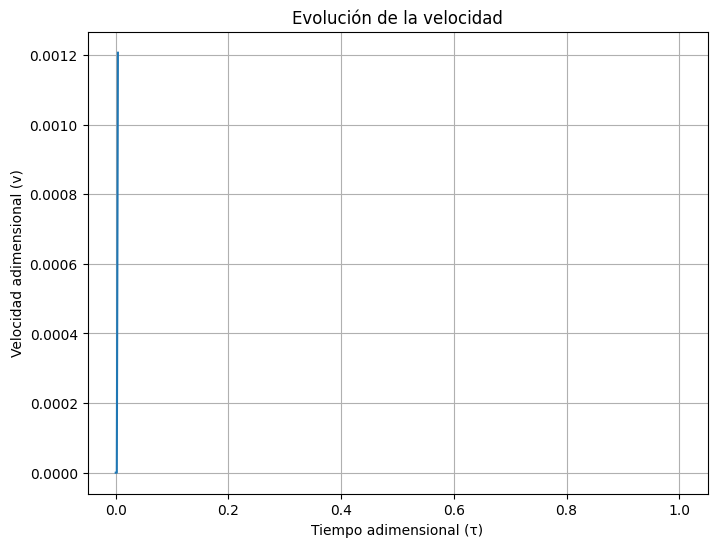

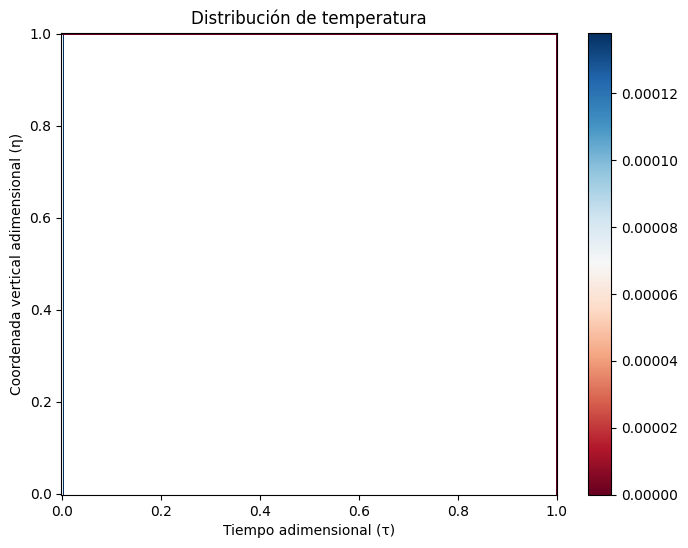

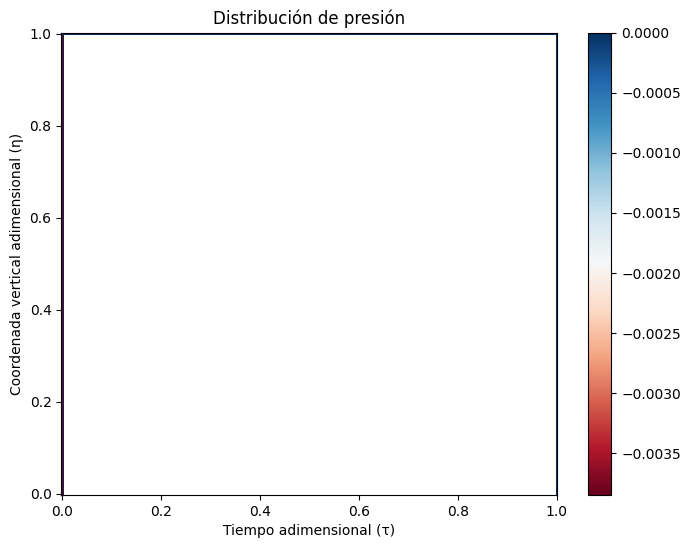

In [21]:
# Gráfico lineal de v
plt.figure(figsize=(8, 6))
plt.plot(tau, v)
plt.xlabel('Tiempo adimensional (τ)')
plt.ylabel('Velocidad adimensional (v)')
plt.title('Evolución de la velocidad')
plt.grid()
plt.show()

# Mapa de calor de θ*
plt.figure(figsize=(8, 6))
plt.pcolormesh(tau, eta, theta_star, cmap='RdBu')
plt.colorbar()
plt.xlabel('Tiempo adimensional (τ)')
plt.ylabel('Coordenada vertical adimensional (η)')
plt.title('Distribución de temperatura')
plt.show()

# Mapa de calor de xi
plt.figure(figsize=(8, 6))
plt.pcolormesh(tau, eta, xi, cmap='RdBu')
plt.colorbar()
plt.xlabel('Tiempo adimensional (τ)')
plt.ylabel('Coordenada vertical adimensional (η)')
plt.title('Distribución de presión')
plt.show()

In [22]:
xi_min = v_e**2/(Ri * phi)
print(f'xi en el estacionario: {xi_min:.4e}')
print(f'phi/v_e = {phi/v_e:.4f} \nRa^-1 = {Ra**-1:.2e} \nv_e**-1 = {v_e**-1:.4f}')

xi en el estacionario: 4.0807e-02
phi/v_e = 0.6271 
Ra^-1 = 3.91e-07 
v_e**-1 = 0.1381


In [23]:
print(xi_min)

0.0408069902690264


## SIMULACION USANDO $\frac{d \xi}{d \eta} = 0$

In [24]:
# Definición de variables y condiciones iniciales
M = 256 # Número de puntos en la dirección vertical
N = 512 # Número de puntos en la dirección temporal
eta = np.linspace(0, 1, M)  # Coordenada vertical adimensional
tau = np.linspace(0, 1, N)  # Coordenada temporal adimensional
deta = (eta[-1] - eta[0])/M
dtau = (tau[-1] - tau[0])/N 
v = np.zeros(N)  # Velocidad adimensional
theta_star = np.zeros((M, N))  # Temperatura adimensional
xi = np.zeros((M, N))  # Presión adimensional, inicialmente todo el espacio se encuentra a p_atm

# Condiciones iniciales
v[0] = 0.0  # Velocidad inicial cero
# theta_star[:, 0] = 0.0   Temperatura inicial uniforme
# xi[:, 0] = 0.0 Diferencia de presión entre el interior del tubo y el exterior

# Simulación numérica

for t in range(1, N-1):


    # Calculo de la velocidad en el instante i+1 a partir de la presión en eta = 0 del instante anterior:
    v[t] = v[t-1] + deta * (- Ra**-1 * v[t-1] + theta_star[0, t-1]/v_e)

    # Calculo de las distribuciones de temperatura y presion en el espacio para el instante i+1:
    for x in range(M-1):
         
        dtheta_deta = (theta_star[x+1, t-1] - theta_star[x, t-1]) / deta
        d2theta_deta2 = (theta_star[x+1, t-1] - 2 * theta_star[x, t-1] + theta_star[x-1, t-1]) / deta**2
        theta_star[x, t] = theta_star[x, t-1] - dtau * (2 * Ri**-1 * v_e * v[t] * dtheta_deta
                                            - delta * d2theta_deta2
                                            + 2 * Ri**-1 * LAMBDA * (theta_star[x, t-1] - 1))


print('velocidad = ' + str(v[:5]))
print('temperaturas = ' + str(theta_star[:5,:5]))
print('presiones = ' + str(xi[:5,:5]))

velocidad = [0.00000000e+00 0.00000000e+00 3.72270226e-08 1.11678493e-07
 2.23351835e-07]
temperaturas = [[0.00000000e+00 6.90157071e-05 1.38026640e-04 2.07032799e-04
  2.76034184e-04]
 [0.00000000e+00 6.90157071e-05 1.38026651e-04 2.07032832e-04
  2.76034251e-04]
 [0.00000000e+00 6.90157071e-05 1.38026651e-04 2.07032832e-04
  2.76034251e-04]
 [0.00000000e+00 6.90157071e-05 1.38026651e-04 2.07032832e-04
  2.76034251e-04]
 [0.00000000e+00 6.90157071e-05 1.38026651e-04 2.07032832e-04
  2.76034251e-04]]
presiones = [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


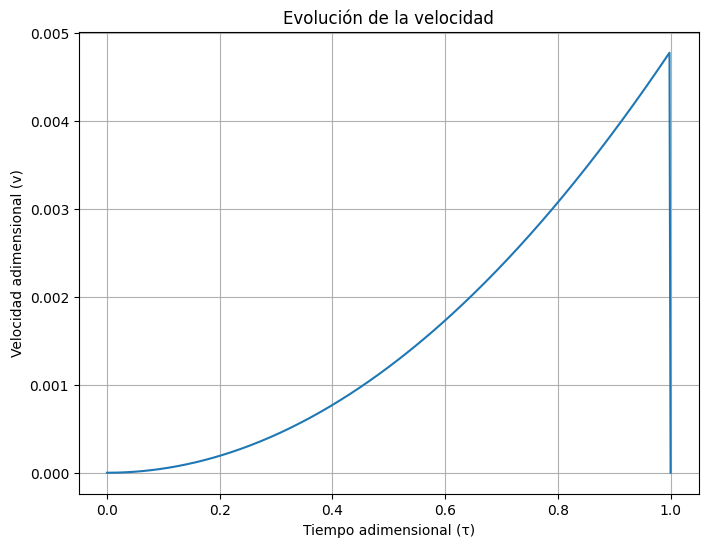

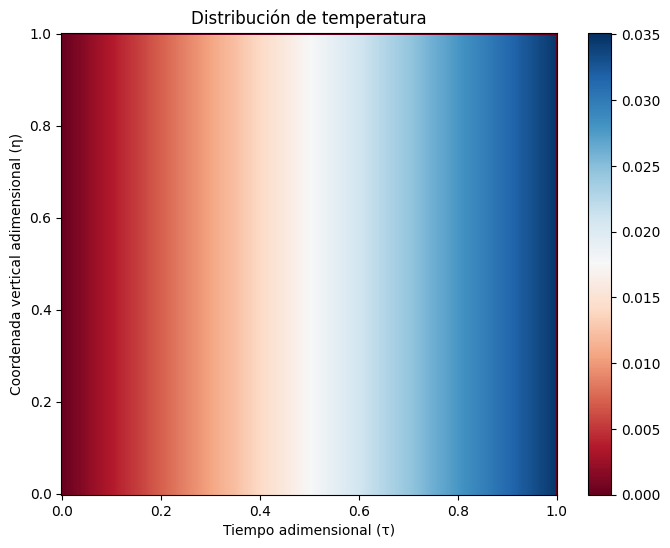

In [25]:
# Gráfico lineal de v
plt.figure(figsize=(8, 6))
plt.plot(tau, v)
plt.xlabel('Tiempo adimensional (τ)')
plt.ylabel('Velocidad adimensional (v)')
plt.title('Evolución de la velocidad')
plt.grid()
plt.show()

# Mapa de calor de θ*
plt.figure(figsize=(8, 6))
plt.pcolormesh(tau, eta, theta_star, cmap='RdBu')
plt.colorbar()
plt.xlabel('Tiempo adimensional (τ)')
plt.ylabel('Coordenada vertical adimensional (η)')
plt.title('Distribución de temperatura')
plt.show()

## SIMULACIÓN TOMANDO LA ECUACIÓN DE LOS GASES EN LUGAR DE LA ECUACIÓN DE BERNOUILLI

In [26]:
R_gases =  8.31446261815324 # cte de los gases [J/(K·mol)]
Vol = math.pi * R**2 * L # Volumen en el interior de la tuberia
pi_star = R_gases * delta_T / (rho_0 * g * L * Vol)
pi_0 = R_gases * T_a / (rho_0 * g * L * Vol)

In [30]:
# Definición de variables y condiciones iniciales
M = 256 # Número de puntos en la dirección vertical
N = 512 # Número de puntos en la dirección temporal
eta = np.linspace(0, 1, M)  # Coordenada vertical adimensional
tau = np.linspace(0, 1, N)  # Coordenada temporal adimensional
deta = (eta[-1] - eta[0])/M
dtau = (tau[-1] - tau[0])/N 
v = np.zeros(N)  # Velocidad adimensional inicialmente a 0
theta_star = np.zeros((M, N))  # Temperatura adimensional inicialmente a 0
xi = np.ones((M, N))  # Presión adimensional, inicialmente todo el espacio se encuentra a p_atm

# Simulación numérica

for t in range(1, N-1):


    # Calculo de la velocidad en el instante i+1 a partir de la presión en eta = 0 del instante anterior:
    dxi_deta = (xi[1, t-1] - xi[0, t-1]) / deta
    v[t] = v[t-1] + dtau * (phi / v_e * dxi_deta + Ra**-1 * v[t-1] - theta_star[0, t-1] / v_e)

    # Calculo de las distribuciones de temperatura y presion en el espacio para el instante i+1:
    for x in range(M-1):
         
        dtheta_deta = (theta_star[x+1, t-1] - theta_star[x, t-1]) / deta
        d2theta_deta2 = (theta_star[x+1, t-1] - 2 * theta_star[x, t-1] + theta_star[x-1, t-1]) / deta**2
        theta_star[x, t] = theta_star[x, t-1] - dtau * (2 * Ri**-1 * v_e * v[t] * dtheta_deta
                                            - delta * d2theta_deta2
                                            + 2 * Ri**-1 * LAMBDA * (theta_star[x, t-1] - 1))
        
        xi[M-2-x, t] = xi[M-1-x, t] - deta * (pi_star * dtheta_deta + 1)   


print('velocidad = ' + str(v[:5]))
print('temperaturas = ' + str(theta_star[:5,:5]))
print('presiones = ' + str(xi[:5,:5]))

velocidad = [0.         0.         0.00122478 0.00244953 0.00367427]
temperaturas = [[0.00000000e+00 6.90157071e-05 1.38026640e-04 2.07032799e-04
  2.76034184e-04]
 [0.00000000e+00 6.90157071e-05 1.38026651e-04 2.07032832e-04
  2.76034251e-04]
 [0.00000000e+00 6.90157071e-05 1.38026651e-04 2.07032832e-04
  2.76034251e-04]
 [0.00000000e+00 6.90157071e-05 1.38026651e-04 2.07032832e-04
  2.76034251e-04]
 [0.00000000e+00 6.90157071e-05 1.38026651e-04 2.07032832e-04
  2.76034251e-04]]
presiones = [[1.         0.00390625 0.00390625 0.00390625 0.00390625]
 [1.         0.0078125  0.0078125  0.0078125  0.0078125 ]
 [1.         0.01171875 0.01171875 0.01171875 0.01171875]
 [1.         0.015625   0.015625   0.015625   0.015625  ]
 [1.         0.01953125 0.01953125 0.01953125 0.01953125]]


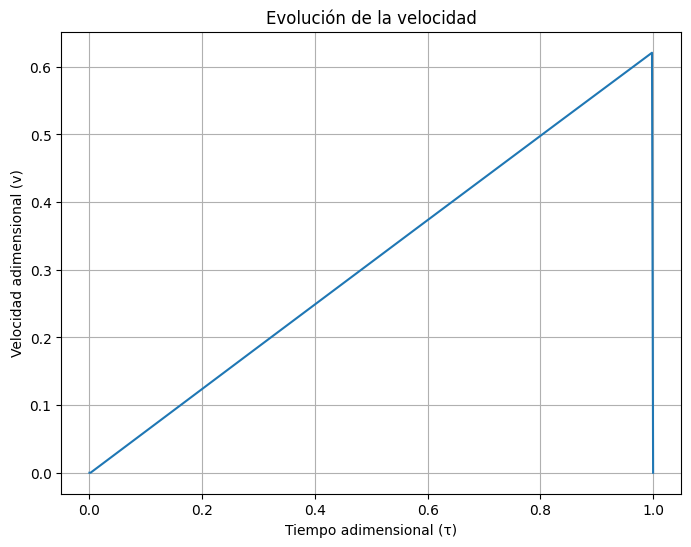

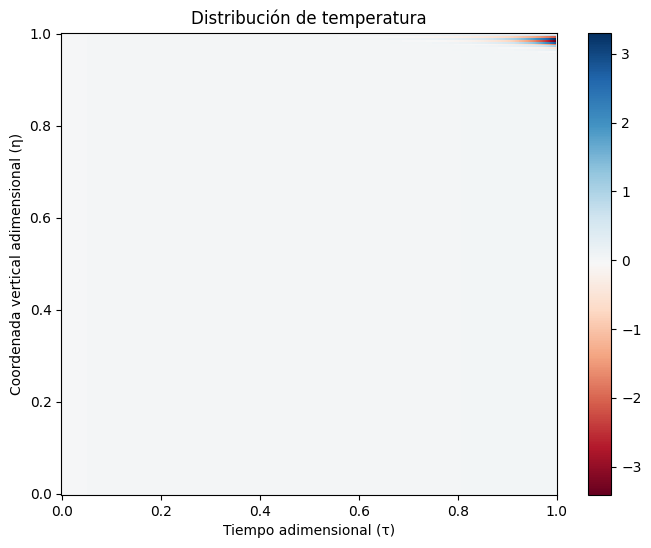

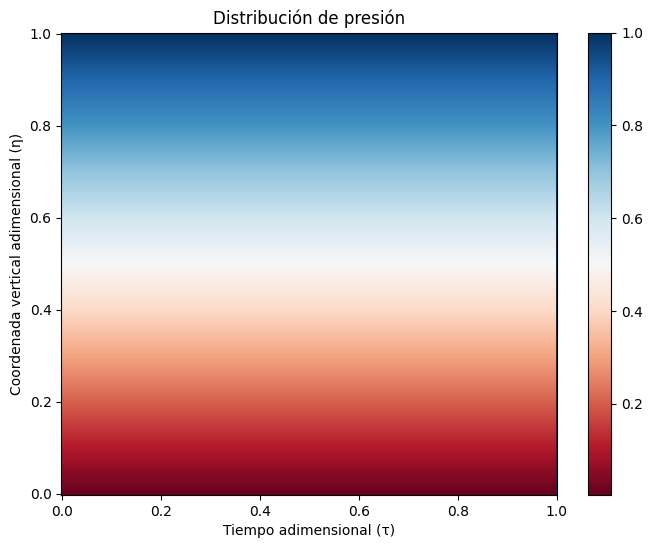

In [31]:
# Gráfico lineal de v
plt.figure(figsize=(8, 6))
plt.plot(tau, v)
plt.xlabel('Tiempo adimensional (τ)')
plt.ylabel('Velocidad adimensional (v)')
plt.title('Evolución de la velocidad')
plt.grid()
plt.show()

# Mapa de calor de θ*
plt.figure(figsize=(8, 6))
plt.pcolormesh(tau, eta, theta_star, cmap='RdBu')
plt.colorbar()
plt.xlabel('Tiempo adimensional (τ)')
plt.ylabel('Coordenada vertical adimensional (η)')
plt.title('Distribución de temperatura')
plt.show()

# Mapa de calor de xi
plt.figure(figsize=(8, 6))
plt.pcolormesh(tau, eta, xi, cmap='RdBu')
plt.colorbar()
plt.xlabel('Tiempo adimensional (τ)')
plt.ylabel('Coordenada vertical adimensional (η)')
plt.title('Distribución de presión')
plt.show()